# Part 3: Noah Weiss

### Import Relevant Libraries

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import logging

### Initialize Log

In [2]:
# Configure logging
logging.basicConfig(filename='anomalies.log', level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s', filemode='w')

# Create a logger
logger = logging.getLogger()

### Define Functions

In [3]:
def get_image_resolution(image_path) -> tuple[int, int]:
    """
    function receives an image name, and returns the width and height of the image
    """
    fixed_image_path = f'Q3_images/images/{image_path[:-4]}.jpg'
    with Image.open(fixed_image_path) as img:
        width, height = img.size
    return width, height

### Coordinates Anomalies:

Description: Anomalies that are found in the x,y coordinates of bounding boxes, including values less than or equal to zero and bbox's that exceed the image boundaries.

These are found by checking that the x_center and y_center values are non-zero and positive, and within bounds of the image dimentions. We also check that the bbox border is fully in the image dimentions.

In [4]:
def check_coordinates(row) -> bool:
    """
    function recieves a row of data from the GT data, and checks if there are issues with the coordinates
    """
    error = 0.00000000001  # used for math error
    if row['x_center'] <= 0:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has non positive x_center: {row['x_center']}")
        return True
    if row['y_center'] <= 0:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has non positive y_center: {row['y_center']}")
        return True
    image_width, image_height = get_image_resolution(row["name"])
    if row['x_center'] > image_width:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has x_center {row['x_center']} that exceeds the image width: {image_width}")
        return True
    if row['y_center'] > image_height:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has y_center {row['y_center']} that exceeds the image height: {image_height}")
        return True
    if row['x_center'] + row['width'] / 2 > image_width + error:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has box limit {row['x_center'] + row['width'] / 2} that exceeds the image width: {image_width}")
        return True
    if row['y_center'] + row['height'] / 2 > image_height + error:
        logger.warning(f"Coordinates anomaly -> Index {row.name} has box limit {row['y_center'] + row['height'] / 2} that exceeds the image height: {image_height}")
        return True
    return False

### Width and Height Anomalies:

Description: Anomalies that are identified if the sizes of the width or height values are less than or equal to zero.


These are found by checking that the width and height value are non-zero and positive.

In [5]:
def check_sizes(row) -> bool:
    """
    function receives a row of data from the GT data, and checks if there are issues with the sizes of width and height
    """
    if row['width'] <= 0:
        logger.warning(f"Sizes anomaly -> Index {row.name} has non positive width: {row['width']}")
        return True
    if row['height'] <= 0:
        logger.warning(f"Sizes anomaly -> Index {row.name} has non positive height: {row['height']}")
        return True
    return False

### Rider Status Anomalies:

Description: Anomalies are identified if the rider status flag (is_rider_on_2_wheels) has a value other than 0 or 1, or has a value of 1 on an object that is not labeled as BIKE or MOTOR.

These are found by checking that the is_rider_on_2_wheels isn't a value that not 0 or 1, and also by checking that the label is BIKE or MOTOR if the is_rider_on_2_wheels flag is 1.

In [6]:
def check_rider_status(row) -> bool:
    """
    function receives a row of data from the GT data, and checks if there is an issue with the is_rider_on_2_wheels flag
    """
    if row['is_rider_on_2_wheels'] not in [0, 1]:
        logger.warning(f"Rider Status anomaly -> Index {row.name} has is_rider_on_2_wheels thats not 0 or 1: {row['is_rider_on_2_wheels']}")
        return True
    if row['label'] not in ['BIKE', 'MOTOR'] and row['is_rider_on_2_wheels'] == 1:
        logger.warning(f"Rider Status anomaly -> Index {row.name} is a non 2W label {row['label']} and has is_rider_on_2_wheels: {row['is_rider_on_2_wheels']}")
        return True
    return False

### D3 Separation Anomalies:

Description: Anomalies are identified if the 3D separation value (d3_separation) is not in the bounds of the box it belongs to, or if a non 4-wheel object is given a 3D separation.

These are founds by checking that the the d3_separation value is indeed in the bounds of the box, and that the label is of a 4-wheel vehicle.

In [7]:
def check_d3_separation(row) -> bool:
    """
    function receives a row of data from the GT data, and checks that the d3_separation is within the bounds of the box
    """
    w4_labels = ['CAR', 'BUS', 'TRUCK', 'PICK_UP_CAR', 'VAN', 'TRACTOR', 'MOTOR', 'RV', 'TRAILER', 'MINI_TRUCK']
    illegal_3d_labels = ['PERSON', 'RIDER', 'TRAIN']
    if row['label'] in w4_labels and row['d3_separation'] != 0 and abs(row['x_center'] - row['d3_separation']) >= row['width'] / 2:
        logger.warning(f"d3 Seperation anomaly -> Index {row.name} has d3_separation {row['d3_separation']} that not in the boundaries of the bbox: {row['x_center'] - row['width'] / 2} - {row['x_center'] + row['width'] / 2}")
        return True
    if row['label'] in illegal_3d_labels and row['d3_separation'] != 0:
        logger.warning(f"d3 Seperation anomaly -> Index {row.name} has label {row['label']} but has d3_seperation {row['d3_separation']}")
        return True
    return False

### Load GT Data

In [8]:
gt_data = pd.read_csv('GT.tsv', delimiter='\t')

### Check For Anomalies

In [9]:
anomalies = {
    'coordinates': gt_data.apply(check_coordinates, axis=1),
    'sizes': gt_data.apply(check_sizes, axis=1),
    'rider_status': gt_data.apply(check_rider_status, axis=1),
    'd3_separation': gt_data.apply(check_d3_separation, axis=1)
}

### Count How Many Anomalies There Are

In [10]:
anomalies_count = 0
for anomaly_type, anomaly_list in anomalies.items():
    anomalies_count += gt_data[anomaly_list].shape[0]
print(f"Found total of {anomalies_count} anomalies")

Found total of 7 anomalies


### Present The Coordinates Anomalies

In [11]:
gt_data[anomalies['coordinates']]

,name,x_center,y_center,width,height,label,is_rider_on_2_wheels,d3_separation


### Present The Width And Height Sizes Anomalies

In [12]:
gt_data[anomalies['sizes']]

,name,x_center,y_center,width,height,label,is_rider_on_2_wheels,d3_separation
370,1686074588000218.png,1809.049869,1171.853791,53.025594,-49.27078,CAR,0,0.0
438,1686074741999958.png,1316.000000,1192.500000,-32.000000,87.00000,PERSON,0,0.0


### Present The Rider Status Anomalies

In [13]:
gt_data[anomalies['rider_status']]

,name,x_center,y_center,width,height,label,is_rider_on_2_wheels,d3_separation
3628,1686075272666719.png,1808.5,1162.0,61.0,48.0,CAR,1,0.000000
3636,1686075272666719.png,358.0,1151.0,694.0,104.0,PICK_UP_CAR,1,281.287577


### Present The D3 Separation Anomalies

In [14]:
gt_data[anomalies['d3_separation']]

,name,x_center,y_center,width,height,label,is_rider_on_2_wheels,d3_separation
13,1686074578666959.png,2807.000000,1150.000000,92.000000,24.000000,CAR,0,2706.290369
960,1686074828000328.png,2028.500000,1148.000000,17.000000,40.000000,PERSON,0,1934.343382
6435,1686079021333365.png,1754.473465,1144.199521,25.660969,8.721772,TRUCK,0,1852.186844


### Present The Frames That Have The Anomalies With BBox

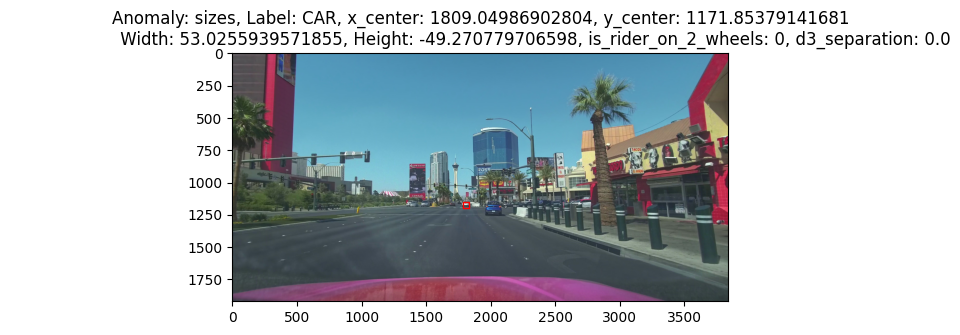

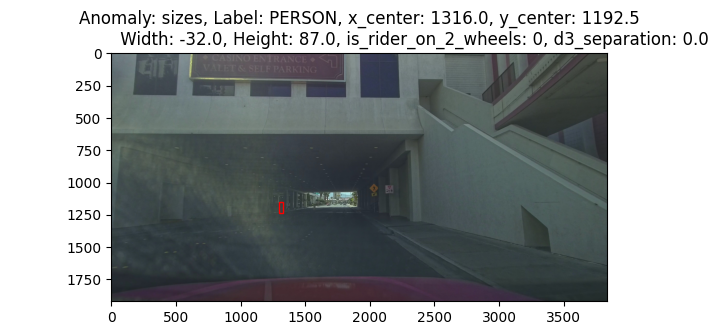

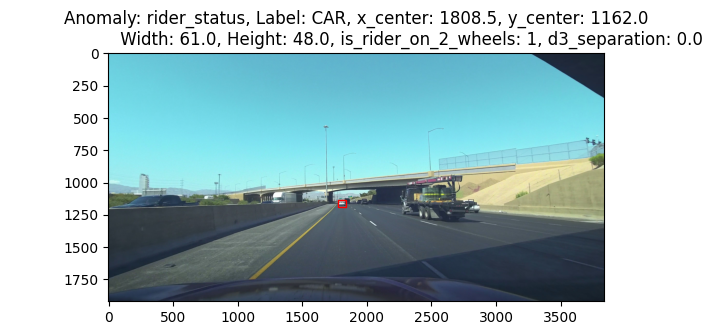

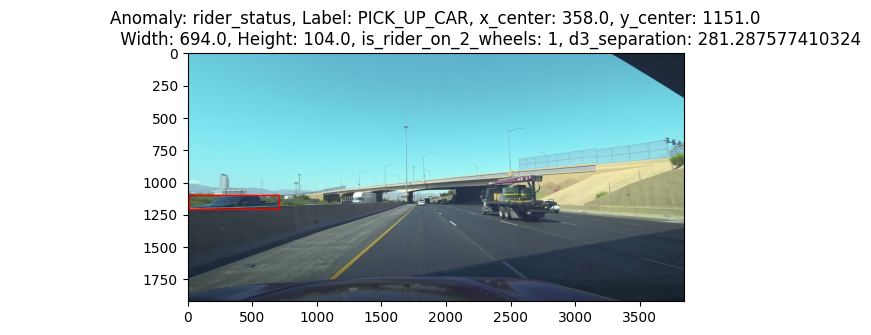

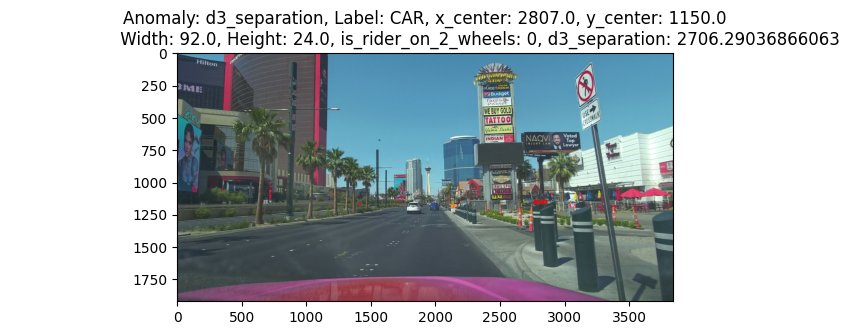

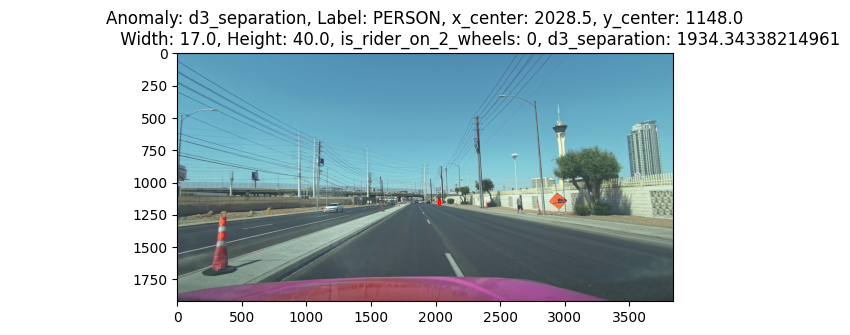

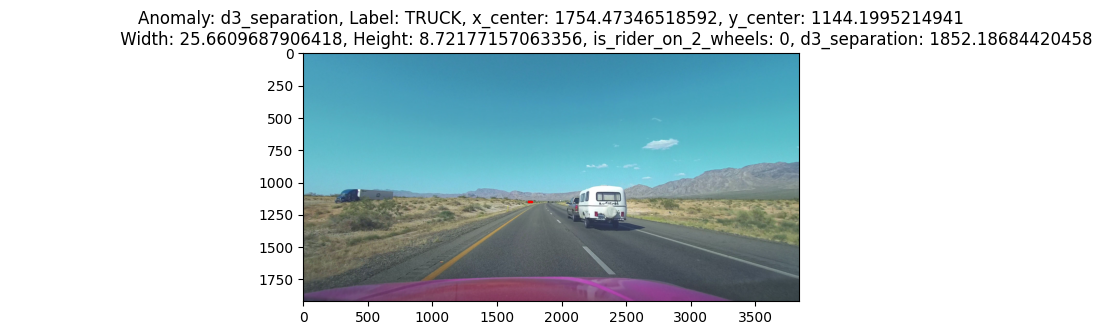

In [15]:
# Open image files and draw bounding boxes
image_dir = 'Q3_images/images'
for anomaly, anomaly_list in anomalies.items():
    anomaly_indices = anomaly_list[anomaly_list].index
    for idx in anomaly_indices:
        row = gt_data.iloc[idx]
        image_path = os.path.join(image_dir, row['name'][:-3] + 'jpg')
        if os.path.exists(image_path):
            image = Image.open(image_path)
            plt.imshow(image)
            ax = plt.gca()
            rect = patches.Rectangle((row['x_center'] - row['width'] / 2, row['y_center'] - row['height'] / 2), row['width'], row['height'], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.title(f"Anomaly: {anomaly}, Label: {row['label']}, x_center: {row['x_center']}, y_center: {row['y_center']}\n \
                    Width: {row['width']}, Height: {row['height']}, is_rider_on_2_wheels: {row['is_rider_on_2_wheels']}, d3_separation: {row['d3_separation']}")
            fig_manager = plt.get_current_fig_manager()
            fig_manager.resize(2200, 1200)
            plt.show()
        else:
            print("Couldnt find image:", image_path)